In [1]:
import os
import sys
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pandas as pd
import time

from numpy import sin,cos,arcsin,arccos,dot,pi,sqrt,exp
from scipy.signal import find_peaks
from scipy.special import erf,iv
from tqdm import tqdm
from spacepy import pycdf
from scipy.interpolate import splrep,splev
from scipy.integrate import simpson
from tletools import tle,TLE
from matplotlib import dates as mdates
from scipy.ndimage import uniform_filter1d
%matplotlib widget
plt.style.use('default')

C:\Users\soumy\anaconda3\lib\site-packages\spacepy\time.py:2365: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [2]:
days = mdates.DateLocator()   # date
daysFmt = mdates.DateFormatter('%d')
hoursFmt = mdates.DateFormatter('%H:%M')

In [3]:
sat = 'GRACEA'
sat_in_filename = 'graceA'
start = dt.datetime(2005,8,1,0,0,0)
stop = dt.datetime(2005,9,1,0,0,0)
no_of_days = int(np.ceil((stop - start)/dt.timedelta(days=1)))

R_const = 8.31
k_B = 1.38 * (10**-23)
m_O=16; m_O2=32; m_N=14; m_N2=28; m_H=1; m_He=4;

R_O = (R_const/m_O)*1000;
R_N = (R_const/m_N)*1000;
R_O2 = (R_const/m_O2)*1000;
R_N2 = (R_const/m_N2)*1000;
R_He = (R_const/m_He)*1000;
R_H = (R_const/m_H)*1000;

omega = [0,0,2*np.pi/86400]

m_p = 1.6726 * 10**-27
m_grace = 432
R_earth = 6.371*10**6
n0 = 1.0e14

In [5]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\'
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = sat + '_Mehta_' + start.strftime("%Y-%m-%d") +'.csv'
GRACE_Data = pd.read_csv(filename)
GRACE_Data.index = pd.DatetimeIndex(GRACE_Data['Unnamed: 0'])
GRACE_Data = GRACE_Data.drop('Unnamed: 0',axis=1)
df1=GRACE_Data.loc[start:stop]
#.iloc[np.arange(0,len(GRACE_Data),12),:]

In [7]:
GRACE_Data['Density_New (kg/m^3)'].mean()

1.9813502759951318e-13

In [ ]:
# fig,ax = plt.subplots(3,1,figsize=[8,6],gridspec_kw={'height_ratios': [1,1,1.5]},sharex=True)
# ax[0].plot(np.rad2deg(df1['Pitch (rad)'][:1440]),c='green')

# ax[0].set_ylabel('Pitch angle (deg)',fontsize=12)

# ax[1].plot(np.rad2deg(df1['Yaw (rad)'][:1440]),c='purple')
# ax[1].set_ylabel('Yaw angle (deg)',fontsize=12)

# ax[2].plot(df1['Proj_Area_New (m^2)'][:1440],c='tab:orange')
# ax[2].set_ylabel('Projected Area ($m^{2}$)',fontsize=12)
# ax[2].set_xlabel('UT on Aug 01, 2005',fontsize=12)
# ax[2].xaxis.set_major_formatter(hoursFmt);
# for i in range(3):
#     ax[i].tick_params(labelsize=12)
# plt.tight_layout()
# plt.show()

In [9]:
# plt.figure(figsize=[10,3])
# plt.plot(df1['Proj_Area_New (m^2)'])
# plt.xlim([start,start+dt.timedelta(days=1)])
# plt.ylabel('Projected area ($m^{2}$)')
# plt.yticks([1,1.05,1.1,1.15,1.20,1.25])
# plt.tick_params(labelsize=12)

In [6]:
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\OMNI\\'
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/OMNI/'
os.chdir(filepath)
filename = "omni_min_SnNZAZ1U1C.txt"
SW_Data_min = np.loadtxt(filename,dtype = float)
time_array = pd.DatetimeIndex([dt.datetime(int(SW_Data_min[:,0][i]),1,1,0,0,0) +
               dt.timedelta(days = SW_Data_min[:,1][i]-1) +
               dt.timedelta(hours = SW_Data_min[:,2][i]) + dt.timedelta(minutes = SW_Data_min[:,3][i])
                               for i in range(len(SW_Data_min))])

SW_Data_min = pd.DataFrame(SW_Data_min)
SW_Data_min.columns = ['Year','DOY','Hour','Minutes','B0','Bx','By','Bz','flow speed','flow pressure','electric field',
                     'AE','AL','AU','SYM/H','PCN']
SW_Data_min.index = pd.DatetimeIndex(time_array)
SW_Data_min = SW_Data_min.loc[start:stop]

In [9]:
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\SPDF\\'
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/SPDF/'
os.chdir(filepath)

filename = 'grace1_20221029054657_14241.cdf';
cdf = pycdf.CDF(filename)
time_array = pd.DatetimeIndex(cdf['Epoch'])
XYZ_TOD = pd.DataFrame(cdf['XYZ_TOD'],columns = ['X','Y','Z'],index = time_array)
RADIUS = pd.DataFrame({'Radius' : list(cdf['RADIUS'])},index = time_array)
RADIUS_int = RADIUS.resample('10S').interpolate(method = 'spline',order = 3)

In [10]:
Z = XYZ_TOD['Z'][(XYZ_TOD.index>=start) & (XYZ_TOD.index<=stop)]
idxz = np.where(np.diff(np.sign(Z)) > 0)[0]
orbit_end = Z.index[idxz] 
time_avg = [orbit_end[i] + (orbit_end[i+1] - orbit_end[i])/2 for i in range(len(orbit_end)-1)]

In [11]:
orbit_end_sel = orbit_end[(orbit_end>=dt.datetime(2005,8,22))&(orbit_end<=dt.datetime(2005,8,29))]
time_avg_sel = [orbit_end_sel[i] + (orbit_end_sel[i+1] - orbit_end_sel[i])/2 for i in range(len(orbit_end_sel)-1)]

In [13]:
trs=find_peaks(-RADIUS['Radius'])[0]
per = time_array[trs]
per_loc=[];
for p0 in per:
    per_loc.append(df1.index.get_loc(p0,method='nearest'))

C:\Users\soumy\AppData\Local\Temp\ipykernel_5928\2412886852.py:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  per_loc.append(df1.index.get_loc(p0,method='nearest'))


## functions

In [5]:
def sigma_n(m_atm,m_s):
    ## m_atm = molecular mass of incident particle
    ## m_s = molecular mass of surface element
    mu = m_atm/m_s
    alpha = 3.0*mu/((1+mu)**2)
    alpha_n = 2*alpha - 1
    if alpha_n < 0:
        alpha_n = 0
    return 1 - sqrt(1-alpha_n)

def theta(key,temp,nO):
    k_B = 1.38e-23
    P_O = nO*k_B*temp ## partial pressure of O
    if key == "DRIA":
        K = 1.44e6;        
    elif key == "CLL":
        K = 2.89e6;
    th = K*P_O/(1 + K*P_O)
    return th

def gamma1(x):
    return (1/(2*sqrt(pi)))*(exp(-x**2) + sqrt(pi)*x*(1+erf(x)))

def gamma2(x):
    return (1/(2*sqrt(pi)))*(x*exp(-x**2) + (sqrt(pi)/2)*(1 + 2*(x**2))*(1+erf(x)))

def C1(x):
    return (2*x**2 + 3)*iv(0,0.5*x**2) + (2*x**2 + 1)*iv(1,0.5*x**2)
def C2(x):
    return (x**2 + 1)*iv(0,0.5*x**2) + (x**2)*iv(1,0.5*x**2)

def drag_CLL_plane(v,R,temp,angle,sigma_t,sigma_n,T_s):
    ## angle = angle between surface normal and velocity vector
    s = v/sqrt(2*R*temp)
    v_w = sqrt(pi*R*T_s/2)
    g = cos(angle)
    mu = g*s 
    c1 = sigma_t*(1 - g**2)*gamma1(mu)
    c2 = (2-sigma_n)*g*gamma2(mu)/s
    c3 = sigma_n*(v_w/v)*gamma1(mu)*g
    return (2/s)*(c1+c2+c3)

def drag_CLL_sphere(v,R,temp,sigma_t,sigma_n,T_s):
    v_a = sqrt(2*R*temp);
    v_w = sqrt(pi*R*T_s/2);
    s = v/v_a
    p0 = (2 - sigma_n + sigma_t)/(2*(s**3))
    p1= (((4*(s**4)) + (4*(s**2)) - 1)*erf(s)/(2*s)) + ((2*s**2 + 1)*exp(-s**2)/sqrt(pi))
    p2 = (4/3)*sigma_n*(v_w/v) 
    return (p0*p1) + p2

def drag_CLL_cyl(v,R,temp,angle,sigma_t,sigma_n,T_s):
    ## angle = angle between cylindrical axis and velocity vector
    v_a = sqrt(2*R*temp);
    v_w = sqrt(pi*R*T_s/2);
    s = v/v_a
    g = sin(angle)
    mu = g*s
    p0 = (pi/2)*sigma_n*(v_w/v)*(g**2)
    p1 = (sqrt(pi)/(6*s))*(2*sigma_n - sigma_t - 4)*(g**2)*exp(-mu**2/2)*C1(mu)
    p2 = (sqrt(pi)*sigma_t/s)*(1 - g**2)*exp(-mu**2/2)*C2(mu)
    return p0 - p1 + p2

def drag_DRIA_plane(v,R,temp,angle,alpha,T_s):
    s = v/sqrt(2*R*temp)
    g=cos(angle)
    mu = g*s
    P = exp(-mu**2)/s
    Q = 1 + 1/(2*(s**2))
    Z = 1 + erf(g*s)
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    C_D = (P/sqrt(pi)) + (g*Q*Z) + ((g/2)*ratio*((g*sqrt(pi)*Z) + P))
    return C_D

def drag_DRIA_sphere(v,R,temp,alpha,T_s):
    s = v/sqrt(2*R*temp)
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    p0 = (2*s**2 + 1)*exp(-s**2)/(sqrt(pi) * s**3)
    p1 = (4*s**4 + 4*s**2 - 1)*erf(s)/(2 * s**4)
    p2 = (2*sqrt(pi)/3)*ratio
    return p0 + p1 + p2

def drag_DRIA_cyl(v,R,temp,angle,alpha,T_s):
    s = v/sqrt(2*R*temp)
    g=sin(angle)
    mu = g*s
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    p0 = s*sqrt(pi)*(g**2)*(1 + 1/(2 * s**2))*exp(-mu**2/2)*(iv(0,mu**2/2) + iv(1,mu**2/2))
    p1 = (sqrt(pi)/s)*exp(-mu**2/2)*iv(0,mu**2/2)
    p2 = (pi**1.5)*(g**2)*ratio/4
    return p0+p1+p2

a = [0.9551567,0.9551567,3.1554792,0.2282913,3.1554792,0.2282913,2.1673620,6.0711120]
n_a = [(1,0,0),(-1,0,0),(0,0.766044,-0.642787),(0,-0.766044,0.642787),(0,-0.766044,-0.642787),(0,0.766044,0.642787),(0,0,-1),(0,0,1)]

def GRACE_area(pitch,yaw,a,n_a):
    area=0;
    v_unit = (cos(pitch)*cos(yaw),cos(pitch)*sin(yaw),sin(pitch));
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        if angle < pi/2:
            area = area + a[i]*cos(angle)
    area += 0.0461901*cos(pitch) ## the cylindrical boom
    return area

def drag_GRACE_CLL(v,R,temp,pitch,yaw,m_atm,nO,T_s,a,n_a):
    # m_s  = [382,382,60,382,60,382,60,100,382];
    sn = sigma_n(m_atm,120)
    th = theta("CLL",temp,nO)
    v_unit = (cos(pitch)*cos(yaw),cos(pitch)*sin(yaw),sin(pitch))
    CD_CO = 0; CD_CL = 0;
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        # sn = sigma_n(m_atm,m_s[i])
        CD_CO += drag_CLL_plane(v,R,temp,angle,1,1,T_s)*a[i]
        CD_CL += drag_CLL_plane(v,R,temp,angle,1,sn,T_s)*a[i]
    CD_CO += drag_CLL_cyl(v,R,temp,(pi/2)-pitch,1,1,T_s)*0.0461901
    CD_CL += drag_CLL_cyl(v,R,temp,(pi/2)-pitch,1,sn,T_s)*0.0461901
    area = GRACE_area(pitch,yaw,a,n_a);
    C_D = (th*CD_CO + (1-th)*CD_CL)/area;
    return C_D

def drag_GRACE_DRIA(v,R,temp,pitch,yaw,m_atm,nO,T_s,a,n_a):

    th = theta("DRIA",temp,nO)
    alpha_ads=1;
    mu = m_atm/120;
    alpha_s = 3.0*mu/((1+mu)**2);
    # alpha = alpha_s*(1-th) + alpha_ads*th
    v_unit = (cos(pitch)*cos(yaw),cos(pitch)*sin(yaw),sin(pitch))
    CD_CO=0; CD_CL=0;
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        CD_CO += drag_DRIA_plane(v,R,temp,angle,alpha_ads,T_s)*a[i]
        CD_CL += drag_DRIA_plane(v,R,temp,angle,alpha_s,T_s)*a[i]
    CD_CO += drag_DRIA_cyl(v,R,temp,(pi/2)-pitch,alpha_ads,T_s)*0.0461901
    CD_CL += drag_DRIA_cyl(v,R,temp,(pi/2)-pitch,alpha_s,T_s)*0.0461901
    area = GRACE_area(pitch,yaw,a,n_a) 
    C_D = (CD_CO*th + CD_CL*(1-th))/area
    return C_D


In [10]:
area = [GRACE_area(df1['Pitch (rad)'][i],df1['Yaw (rad)'][i],a,n_a) for i in tqdm(range(len(df1)))]

100%|██████████████████████████████████| 44566/44566 [00:02<00:00, 16244.15it/s]


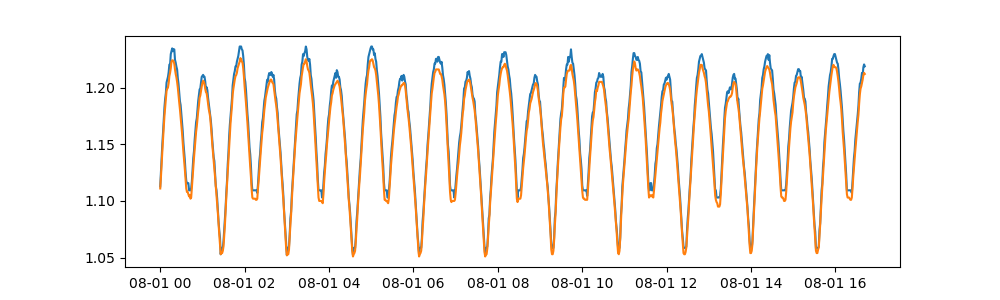

In [15]:
plt.figure(figsize=[10,3])
plt.plot(GRACE_Data.index[:1000],area[:1000])
plt.plot(GRACE_Data['Proj_Area_New (m^2)'][:1000])

## MSIS

### CLL

In [6]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = sat + '_MSIS_jl_' + start.strftime("%Y-%m-%d") + '.csv'
Data_MSIS = pd.read_csv(filename)
Data_MSIS.index = pd.DatetimeIndex(Data_MSIS['Unnamed: 0'])
Data_MSIS = Data_MSIS.loc[start:stop]

In [7]:
mole_frac = pd.DataFrame({'O':[Data_MSIS['nO'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                          'N':[Data_MSIS['nN'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                         'O2':[Data_MSIS['nO2'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                          'N2': [Data_MSIS['nN2'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                          'He': [Data_MSIS['nHe'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                          'H': [Data_MSIS['nH'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                         },index = Data_MSIS.index);
mole_frac_msis=mole_frac

100%|███████████████████████████████████| 44566/44566 [00:06<00:00, 6409.55it/s]


In [39]:
# plt.figure(figsize=[10,2.5])
# plt.plot(mole_frac_msis['O'].loc[start:start+dt.timedelta(days=1)],label= 'MSIS')
# plt.plot(mole_frac_gitm['O'].loc[start:start+dt.timedelta(days=1)],label= 'GITM')
# plt.legend(fontsize=12)
# plt.ylabel('O mole fraction')
# plt.tick_params(labelsize=12)
# # plt.xlim()

In [8]:
m_avg = m_O*mole_frac['O'] + m_O2*mole_frac['O2']+m_N*mole_frac['N'] + m_N2*mole_frac['N2'] + m_He*mole_frac['He'] + m_H*mole_frac['H']

In [11]:
N=len(df1); C_D = [];Area = [];P_O2 = [];th2 = [];
drag_coeff = np.zeros((N,7))
for i in tqdm(range(N)):
    v = df1['Velocity Magnitude (m/s)'][i];
    temp = Data_MSIS['Tz'][i];
    pitch = df1['Pitch (rad)'][i];
    yaw = df1['Yaw (rad)'][i];
    m_atm = m_avg[i];
    nO = Data_MSIS['nO'][i];
    T_s = df1['Surface Temperature (K)'][i];
    CD_O = drag_GRACE_CLL(v,R_O,temp,pitch,yaw,m_atm,nO,T_s,a,n_a)*m_O*mole_frac['O'][i]
    CD_O2= drag_GRACE_CLL(v,R_O2,temp,pitch,yaw,m_atm,nO,T_s,a,n_a)*m_O2*mole_frac['O2'][i]
    CD_N= drag_GRACE_CLL(v,R_N,temp,pitch,yaw,m_atm,nO,T_s,a,n_a)*m_N*mole_frac['N'][i]
    CD_N2= drag_GRACE_CLL(v,R_N2,temp,pitch,yaw,m_atm,nO,T_s,a,n_a)*m_N2*mole_frac['N2'][i]
    CD_He= drag_GRACE_CLL(v,R_He,temp,pitch,yaw,m_atm,nO,T_s,a,n_a)*m_He*mole_frac['He'][i]
    CD_H= drag_GRACE_CLL(v,R_H,temp,pitch,yaw,m_atm,nO,T_s,a,n_a)*m_H*mole_frac['H'][i]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_MSIS_CLL = C_D;  
CD_MSIS_CLL=pd.DataFrame({"C_D":CD_MSIS_CLL,'A':area},index=df1.index)
CD_MSIS_CLL_orbit = [CD_MSIS_CLL.loc[orbit_end[i]:orbit_end[i+1]]['C_D'].mean() for i in range(len(orbit_end)-1)]
# C_D = pd.DataFrame({'C_D':C_D,'A':Area},index = Data_MSIS.index[:N])
# drag_coeff = pd.DataFrame(drag_coeff)
# drag_coeff.index = pd.DatetimeIndex(Data_MSIS.index[:N])
# drag_coeff.columns = ["CD_O","CD_O2","CD_N","CD_N2","CD_He","CD_H","CD_Ar"]

100%|████████████████████████████████████| 44566/44566 [02:21<00:00, 314.28it/s]


NameError: name 'orbit_end' is not defined

In [23]:
N=len(df1); C_D = [];
for i in tqdm(range(N)):
    v = df1['Velocity Magnitude (m/s)'][i];
    temp = Data_MSIS['Tz'][i];
    pitch = df1['Pitch (rad)'][i];
    yaw = df1['Yaw (rad)'][i];
    T_s = df1['Surface Temperature (K)'][i];
    m_atm = m_avg[i];
    nO = Data_MSIS['nO'][i]
    
    CD_O = drag_GRACE_DRIA(v,R_O,temp,pitch,yaw,m_atm,nO,T_s,a,n_a)*m_O*mole_frac['O'][i]
    CD_O2= drag_GRACE_DRIA(v,R_O2,temp,pitch,yaw,m_atm,nO,T_s,a,n_a)*m_O2*mole_frac['O2'][i]
    CD_N= drag_GRACE_DRIA(v,R_N,temp,pitch,yaw,m_atm,nO,T_s,a,n_a)*m_N*mole_frac['N'][i]
    CD_N2= drag_GRACE_DRIA(v,R_N2,temp,pitch,yaw,m_atm,nO,T_s,a,n_a)*m_N2*mole_frac['N2'][i]
    CD_He= drag_GRACE_DRIA(v,R_He,temp,pitch,yaw,m_atm,nO,T_s,a,n_a)*m_He*mole_frac['He'][i]
    CD_H= drag_GRACE_DRIA(v,R_H,temp,pitch,yaw,m_atm,nO,T_s,a,n_a)*m_H*mole_frac['H'][i]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
    
CD_MSIS_DRIA = C_D;
CD_MSIS_DRIA=pd.DataFrame({"C_D":CD_MSIS_DRIA,'A':area},index=df1.index)
CD_MSIS_DRIA_orbit = [CD_MSIS_DRIA['C_D'][(CD_MSIS_DRIA.index>=orbit_end[i])&(CD_MSIS_DRIA.index<=orbit_end[i+1])].mean() for i in range(len(orbit_end)-1)]

100%|████████████████████████████████████| 44566/44566 [01:33<00:00, 478.53it/s]


In [12]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename='GRACEA_CLL_MSIS_' + start.strftime("%Y-%m-%d")+".csv"
CD_MSIS_CLL.to_csv(filename)

In [26]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename='GRACEA_DRIA_MSIS_' + start.strftime("%Y-%m-%d")+".csv"
CD_MSIS_DRIA.to_csv(filename)

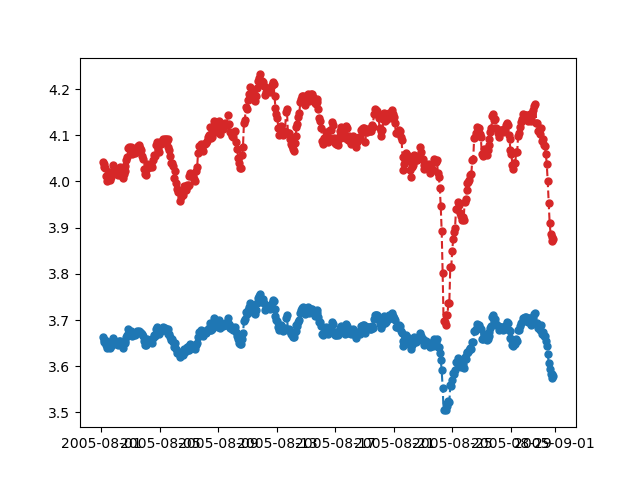

In [27]:
plt.figure()
plt.plot(time_avg,CD_MSIS_CLL_orbit,'--o',ms=5,c='tab:red',label='MSIS (closed-form)')
plt.plot(time_avg,CD_MSIS_DRIA_orbit,'--o',ms=5,c='tab:blue',label='GITM (closed-form)')

## GITM

In [29]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = 'gitm_grace_int_2005-08-22.csv'
Data_GITM = pd.read_csv(filename)
Data_GITM.index=pd.DatetimeIndex(Data_GITM['Unnamed: 0'])

In [31]:
df1 = df1.loc[dt.datetime(2005,8,22):dt.datetime(2005,8,29)]
df1 = df1.iloc[2:N-1,:]
area = [GRACE_area(df1['Pitch (rad)'][i],df1['Yaw (rad)'][i],a,n_a) for i in range(len(df1))]


In [33]:
nO = Data_GITM['O(!U3!NP)'] + Data_GITM['O(!U1!ND)']
nO2 = Data_GITM['O!D2!N']
nN = Data_GITM['N(!U2!ND)'] + Data_GITM['N(!U2!NP)'] + Data_GITM['N(!U4!NS)']
nN2 = Data_GITM['N!D2!N']
nHe = Data_GITM['He']
nH = Data_GITM['H']
ntot = nO+nO2+nN+nN2+nHe+nH
mole_frac = pd.DataFrame({'O':nO/ntot,'O2':nO2/ntot,'N':nN/ntot,'N2':nN2/ntot,'He':nHe/ntot,'H':nH/ntot},
            index=Data_GITM.index)
m_avg = m_O*mole_frac['O'] + m_O2*mole_frac['O2']+m_N*mole_frac['N'] + m_N2*mole_frac['N2'] + m_He*mole_frac['He'] + m_H*mole_frac['H']
mole_frac_gitm = mole_frac

In [21]:
N=len(df1); C_D = [];Area = [];
drag_coeff = np.zeros((N,7))
for i in tqdm(range(N)):
    v = df1['Velocity Magnitude (m/s)'][i];
    temp = Data_GITM['Temperature'][i];
    pitch = df1['Pitch (rad)'][i];
    yaw = df1['Yaw (rad)'][i];
    m_atm = m_avg[i];
    n_O = nO[i];
    T_s = df1['Surface Temperature (K)'][i];
    CD_O = drag_GRACE_CLL(v,R_O,temp,pitch,yaw,m_atm,n_O,T_s)*m_O*mole_frac['O'][i]
    CD_O2= drag_GRACE_CLL(v,R_O2,temp,pitch,yaw,m_atm,n_O,T_s)*m_O2*mole_frac['O2'][i]
    CD_N= drag_GRACE_CLL(v,R_N,temp,pitch,yaw,m_atm,n_O,T_s)*m_N*mole_frac['N'][i]
    CD_N2= drag_GRACE_CLL(v,R_N2,temp,pitch,yaw,m_atm,n_O,T_s)*m_N2*mole_frac['N2'][i]
    CD_He= drag_GRACE_CLL(v,R_He,temp,pitch,yaw,m_atm,n_O,T_s)*m_He*mole_frac['He'][i]
    CD_H= drag_GRACE_CLL(v,R_H,temp,pitch,yaw,m_atm,n_O,T_s)*m_H*mole_frac['H'][i]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_GITM_CLL = C_D ;
CD_GITM_CLL=pd.DataFrame({"C_D":CD_GITM_CLL,'A':area},index=df1.index)
CD_GITM_CLL_orbit = [CD_GITM_CLL['C_D'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

# C_D = pd.DataFrame({'C_D':C_D,'A':Area},index = Data_MSIS.index[:N])
# drag_coeff = pd.DataFrame(drag_coeff)
# drag_coeff.index = pd.DatetimeIndex(Data_MSIS.index[:N])
# drag_coeff.columns = ["CD_O","CD_O2","CD_N","CD_N2","CD_He","CD_H","CD_Ar"]

100%|███████████████████████████████████████████████████████████████████████████| 10071/10071 [00:50<00:00, 199.24it/s]


In [ ]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename='GRACEA_CLL_GITM_' + start.strftime("%Y-%m-%d")+".csv"
CD_GITM_CLL.to_csv(filename)

In [22]:
N=len(df1); C_D = [];
for i in tqdm(range(N)):
    v = df1['Velocity Magnitude (m/s)'][i];
    temp = Data_GITM['Temperature'][i];
    pitch = df1['Pitch (rad)'][i];
    yaw = df1['Yaw (rad)'][i];
    T_s = df1['Surface Temperature (K)'][i];
    m_atm = m_avg[i];
    n_O = nO[i];
    CD_O = drag_GRACE_DRIA(v,R_O,temp,pitch,yaw,m_atm,n_O,T_s)*m_O*mole_frac['O'][i]
    CD_O2= drag_GRACE_DRIA(v,R_O2,temp,pitch,yaw,m_atm,n_O,T_s)*m_O2*mole_frac['O2'][i]
    CD_N= drag_GRACE_DRIA(v,R_N,temp,pitch,yaw,m_atm,n_O,T_s)*m_N*mole_frac['N'][i]
    CD_N2= drag_GRACE_DRIA(v,R_N2,temp,pitch,yaw,m_atm,n_O,T_s)*m_N2*mole_frac['N2'][i]
    CD_He= drag_GRACE_DRIA(v,R_He,temp,pitch,yaw,m_atm,n_O,T_s)*m_He*mole_frac['He'][i]
    CD_H= drag_GRACE_DRIA(v,R_H,temp,pitch,yaw,m_atm,n_O,T_s)*m_H*mole_frac['H'][i]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
    
CD_GITM_DRIA = C_D;
CD_GITM_DRIA=pd.DataFrame({"C_D":CD_GITM_DRIA,'A':area},index=df1.index)
CD_GITM_DRIA_orbit = [CD_GITM_DRIA['C_D'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]


100%|███████████████████████████████████████████████████████████████████████████| 10071/10071 [00:30<00:00, 326.11it/s]


In [ ]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename='GRACEA_DRIA_GITM_' + start.strftime("%Y-%m-%d")+".csv"
CD_GITM_DRIA.to_csv(filename)

In [23]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = 'GRACEA_RSM_CLL_MSIS_'+ start.strftime("%Y-%m-%d") + ".csv"
RSM_CD_MSIS_CLL = pd.read_csv(filename)
RSM_CD_MSIS_CLL.index = pd.DatetimeIndex(RSM_CD_MSIS_CLL['Unnamed: 0'])
RSM_CD_MSIS_CLL_orbit = [RSM_CD_MSIS_CLL['C_D'][(RSM_CD_MSIS_CLL.index>=orbit_end[i])&(RSM_CD_MSIS_CLL.index<=orbit_end[i+1])].mean() for i in range(len(orbit_end)-1)]

In [24]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = 'GRACEA_RSM_CLL_GITM_'+ start.strftime("%Y-%m-%d") + ".csv"
RSM_CD_GITM_CLL = pd.read_csv(filename)
RSM_CD_GITM_CLL.index = pd.DatetimeIndex(RSM_CD_GITM_CLL['Unnamed: 0'])
RSM_CD_GITM_CLL_orbit = [RSM_CD_GITM_CLL['C_D'][(RSM_CD_GITM_CLL.index>=orbit_end[i])&(RSM_CD_GITM_CLL.index<=orbit_end[i+1])].mean() for i in range(len(orbit_end)-1)]

In [25]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = "GRACEA_RSM_CD_DRIA_MSIS_2005-08-01.csv"
RSM_CD_MSIS_DRIA = pd.read_csv(filename)
RSM_CD_MSIS_DRIA.index = pd.DatetimeIndex(RSM_CD_MSIS_DRIA['Unnamed: 0'])
RSM_CD_MSIS_DRIA_orbit = [RSM_CD_MSIS_DRIA['C_D'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

In [26]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = "GRACEA_RSM_CD_DRIA_GITM_2005-08-22.csv"
RSM_CD_GITM_DRIA = pd.read_csv(filename)
RSM_CD_GITM_DRIA.index = pd.DatetimeIndex(RSM_CD_GITM_DRIA['Unnamed: 0'])
RSM_CD_GITM_DRIA_orbit = [RSM_CD_GITM_DRIA['C_D'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

In [27]:
O_MSIS_orbit = [mole_frac_msis['O'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
O_GITM_orbit = [mole_frac_gitm['O'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
Tz_MSIS_orbit = [Data_MSIS['Tz'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
Tz_GITM_orbit = [Data_GITM['Temperature'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]


In [28]:
RSM_CD_GITM_CLL_avg = uniform_filter1d(RSM_CD_GITM_CLL['C_D'],100)
RSM_CD_MSIS_CLL_avg = uniform_filter1d(RSM_CD_MSIS_CLL['C_D'],100)
CD_GITM_CLL_avg = uniform_filter1d(CD_GITM_CLL['C_D'],100)
CD_MSIS_CLL_avg = uniform_filter1d(CD_MSIS_CLL['C_D'],100)

In [29]:
RSM_CD_GITM_DRIA_avg = uniform_filter1d(RSM_CD_GITM_DRIA['C_D'],100)
RSM_CD_MSIS_DRIA_avg = uniform_filter1d(RSM_CD_MSIS_DRIA['C_D'],100)
CD_GITM_DRIA_avg = uniform_filter1d(CD_GITM_DRIA['C_D'],100)
CD_MSIS_DRIA_avg = uniform_filter1d(CD_MSIS_DRIA['C_D'],100)

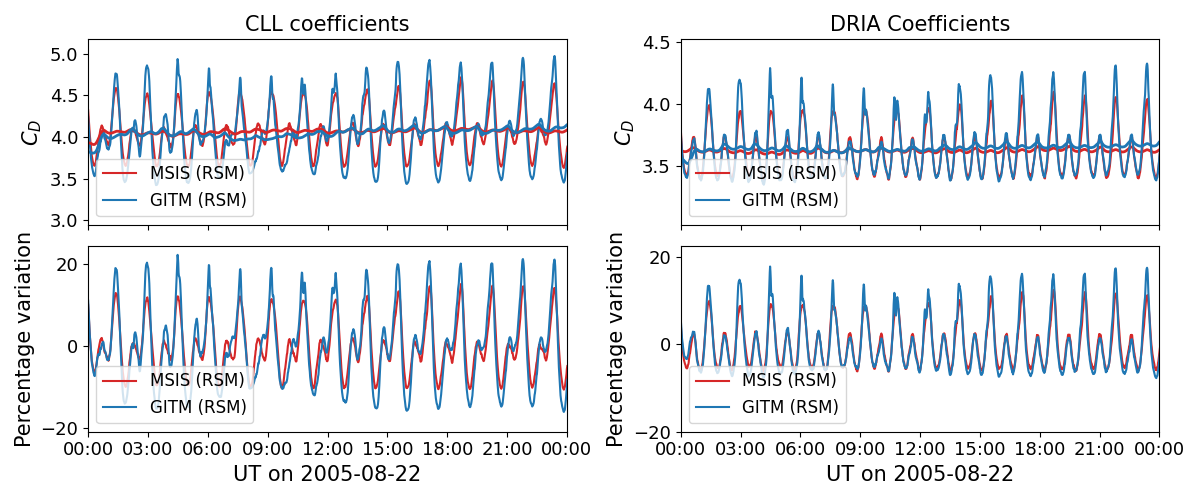

In [30]:
fig,ax = plt.subplots(2,2,figsize=[12,5],sharex=True)

ax[0,0].plot(RSM_CD_MSIS_CLL['C_D'],label='MSIS (RSM)',c='tab:red',lw=1.5)
# ax[0,0].plot(CD_MSIS_CLL['C_D'],'-.',label='MSIS (closed form)',ms=5,c='tab:red',lw=1.5)
ax[0,0].plot(RSM_CD_GITM_CLL['C_D'],label = 'GITM (RSM)',c='tab:blue',lw=1.5)
# ax[0,0].plot(CD_GITM_CLL['C_D'],'-.',label='GITM (closed form)',ms=5,c='tab:blue',lw=1.5)

ax[0,0].plot(RSM_CD_MSIS_CLL.index,RSM_CD_MSIS_CLL_avg,'-',c='tab:red',lw=2)
ax[0,0].plot(RSM_CD_GITM_CLL.index,RSM_CD_GITM_CLL_avg,'-',c='tab:blue',lw=2)
ax[0,0].set_xlim([start,start+dt.timedelta(days=1)]);
# ax[0,0].set_ylim([3.0,5.0])
ax[0,0].set_ylabel("$C_{D}$",fontsize=15);
ax[0,0].legend(fontsize=12,loc='lower left')
ax[0,0].tick_params(labelsize=13)
ax[0,0].xaxis.set_major_formatter(hoursFmt);
ax[0,0].set_title("CLL coefficients",fontsize=15)

ax[1,0].plot((RSM_CD_MSIS_CLL['C_D']-RSM_CD_MSIS_CLL_avg)*100/RSM_CD_MSIS_CLL_avg,label='MSIS (RSM)',c='tab:red',lw=1.5)
ax[1,0].plot((RSM_CD_GITM_CLL['C_D']-RSM_CD_GITM_CLL_avg)*100/RSM_CD_GITM_CLL_avg,label = 'GITM (RSM)',c='tab:blue',lw=1.5)
# ax[1,0].plot((CD_MSIS_CLL['C_D']-CD_MSIS_CLL_avg)*100/CD_GITM_CLL_avg,'-.',label='MSIS (closed form)',c='tab:red',lw=1.5)
# ax[1,0].plot((CD_GITM_CLL['C_D']-CD_GITM_CLL_avg)*100/CD_GITM_CLL_avg,'-.',label = 'GITM (closed form)',c='tab:blue',lw=1.5)


ax[1,0].set_xlim([start,start+dt.timedelta(days=1)]);
ax[1,0].set_yticks([-20,0,20])
ax[1,0].set_xlabel("UT on "+start.strftime("%Y-%m-%d"),fontsize=15)
ax[1,0].set_ylabel("Percentage variation",fontsize=15)
ax[1,0].legend(fontsize=12,loc='lower left')
ax[1,0].tick_params(labelsize=13)
ax[1,0].xaxis.set_major_formatter(hoursFmt);


ax[0,1].plot(RSM_CD_MSIS_DRIA['C_D'],label='MSIS (RSM)',c='tab:red',lw=1.5)
# ax[0,1].plot(CD_MSIS_DRIA['C_D'],'-.',label='MSIS (closed form)',ms=5,c='tab:red',lw=1.5)
ax[0,1].plot(RSM_CD_MSIS_DRIA.index,RSM_CD_MSIS_DRIA_avg,'-',c='tab:red',lw=2)

ax[0,1].plot(RSM_CD_GITM_DRIA['C_D'],label = 'GITM (RSM)',c='tab:blue',lw=1.5)
# ax[0,1].plot(CD_GITM_DRIA['C_D'],'-.',label='GITM (closed form)',ms=5,c='tab:blue',lw=1.5)
ax[0,1].plot(RSM_CD_GITM_DRIA.index,RSM_CD_GITM_DRIA_avg,'-',c='tab:blue',lw=2)

ax[0,1].set_xlim([start,start+dt.timedelta(days=1)]);
# ax[0,1].set_ylim([3.0,5.0])
ax[0,1].set_ylabel("$C_{D}$",fontsize=15)
ax[0,1].legend(fontsize=12,loc='lower left')
ax[0,1].tick_params(labelsize=13)
ax[0,1].xaxis.set_major_formatter(hoursFmt);
ax[0,1].set_title("DRIA Coefficients",fontsize=15)

ax[1,1].plot((RSM_CD_MSIS_DRIA['C_D']-RSM_CD_MSIS_DRIA_avg)*100/RSM_CD_MSIS_DRIA_avg,label='MSIS (RSM)',c='tab:red',lw=1.5)
ax[1,1].plot((RSM_CD_GITM_DRIA['C_D']-RSM_CD_GITM_DRIA_avg)*100/RSM_CD_GITM_DRIA_avg,label = 'GITM (RSM)',c='tab:blue',lw=1.5)
# ax[1,1].plot((CD_MSIS_DRIA['C_D']-CD_MSIS_DRIA_avg)*100/CD_MSIS_DRIA_avg,'-.',label='MSIS (closed form)',c='tab:red',lw=1.5)
# ax[1,1].plot((CD_GITM_DRIA['C_D']-CD_GITM_DRIA_avg)*100/CD_GITM_DRIA_avg,'-.',label = 'GITM (closed form)',c='tab:blue',lw=1.5)

ax[1,1].set_xlim([start,start+dt.timedelta(days=1)]);
ax[1,1].set_yticks([-20,0,20])
ax[1,1].set_xlabel("UT on "+start.strftime("%Y-%m-%d"),fontsize=15)
ax[1,1].set_ylabel("Percentage variation",fontsize=15)
ax[1,1].legend(fontsize=12,loc='lower left')
ax[1,1].tick_params(labelsize=13)
ax[1,1].xaxis.set_major_formatter(hoursFmt);



plt.tight_layout()

filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
os.chdir(filepath)
filename = "GRACE_CD_CLL.png"
plt.savefig(filename,dpi=300)

plt.show()


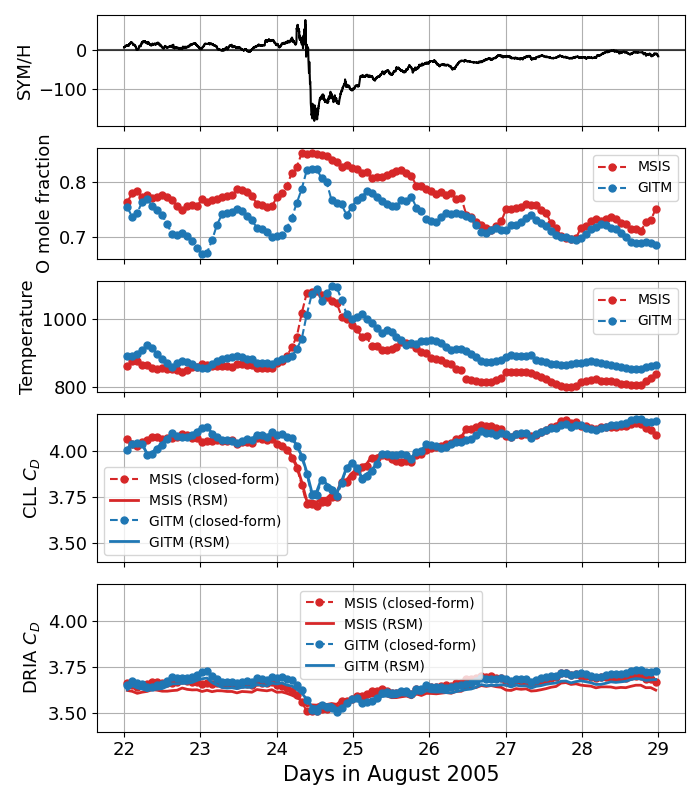

In [31]:
fig,ax = plt.subplots(5,1,figsize=[7,8], gridspec_kw={'height_ratios': [1.5,1.5,1.5,2,2]},sharex=True)

# ax[0].plot(SW_Data_min['Bz'][(SW_Data_min['Bz']<9000)],c='k')
# ax[0].axhline(y=0,ls='-',c='k',alpha=0.7)
# ax[0].set_xticks([start+dt.timedelta(days=i) for i in range(8)])
# ax[0].xaxis.set_major_formatter(daysFmt);
# ax[0].set_ylabel('IMF $B_{z}$',fontsize=12)
# # ax[0].legend(fontsize=10,loc='best')
# ax[0].tick_params(labelsize=12)


ax[0].plot(SW_Data_min['SYM/H'][(SW_Data_min['SYM/H']<9000)],c='k')
ax[0].axhline(y=0,ls='-',c='k',alpha=0.7)
ax[0].set_xticks([start+dt.timedelta(days=i) for i in range(8)])
ax[0].xaxis.set_major_formatter(daysFmt);
ax[0].set_ylabel('SYM/H',fontsize=13)
# ax[1].legend(fontsize=10,loc='best')
ax[0].tick_params(labelsize=13)

ax[1].plot(time_avg,O_MSIS_orbit,'--o',ms=5,c='tab:red',label='MSIS')
ax[1].plot(time_avg,O_GITM_orbit,'--o',ms=5,c='tab:blue',label='GITM')
ax[1].set_xticks([start+dt.timedelta(days=i) for i in range(8)])
ax[1].xaxis.set_major_formatter(daysFmt);
ax[1].set_ylabel('O mole fraction',fontsize=13)
ax[1].legend(fontsize=10,loc='best')
ax[1].tick_params(labelsize=13)

ax[2].plot(time_avg,Tz_MSIS_orbit,'--o',ms=5,c='tab:red',label='MSIS')
ax[2].plot(time_avg,Tz_GITM_orbit,'--o',ms=5,c='tab:blue',label='GITM')
ax[2].set_xticks([start+dt.timedelta(days=i) for i in range(8)])
ax[2].xaxis.set_major_formatter(daysFmt);
ax[2].set_ylabel('Temperature',fontsize=13);
ax[2].legend(fontsize=10,loc='best')
ax[2].tick_params(labelsize=13)


ax[3].plot(time_avg,CD_MSIS_CLL_orbit,'--o',ms=5,c='tab:red',label='MSIS (closed-form)')
ax[3].plot(time_avg,RSM_CD_MSIS_CLL_orbit,'-',c='tab:red',lw=2,label='MSIS (RSM)')
ax[3].plot(time_avg,CD_GITM_CLL_orbit,'--o',ms=5,c='tab:blue',label='GITM (closed-form)')
ax[3].plot(time_avg,RSM_CD_GITM_CLL_orbit,'-',c='tab:blue',lw=2,label='GITM (RSM)')
ax[3].set_xticks([start+dt.timedelta(days=i) for i in range(8)])
ax[3].xaxis.set_major_formatter(daysFmt);
ax[3].set_ylabel('CLL $C_{D}$',fontsize=13);
ax[3].legend(fontsize=10,loc='best')
ax[3].tick_params(labelsize=13)
ax[3].set_ylim([3.4,4.2])

ax[4].plot(time_avg,CD_MSIS_DRIA_orbit,'--o',ms=5,c='tab:red',label='MSIS (closed-form)')
ax[4].plot(time_avg,RSM_CD_MSIS_DRIA_orbit,'-',c='tab:red',lw=2,label='MSIS (RSM)')
ax[4].plot(time_avg,CD_GITM_DRIA_orbit,'--o',ms=5,c='tab:blue',label='GITM (closed-form)')
ax[4].plot(time_avg,RSM_CD_GITM_DRIA_orbit,'-',c='tab:blue',lw=2,label='GITM (RSM)')
ax[4].set_xticks([start+dt.timedelta(days=i) for i in range(8)])
ax[4].xaxis.set_major_formatter(daysFmt);
ax[4].set_ylabel('DRIA $C_{D}$',fontsize=13)
ax[4].legend(fontsize=10,loc='best')
ax[4].tick_params(labelsize=13)
ax[4].set_ylim([3.4,4.2])
plt.xlabel('Days in August 2005',fontsize=15)
for i in range(5):
    ax[i].grid(axis='both',which='both')
plt.tight_layout()



filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
os.chdir(filepath)
filename = "GRACE_CD_CLL_orbit.png"
plt.savefig(filename,dpi=300)



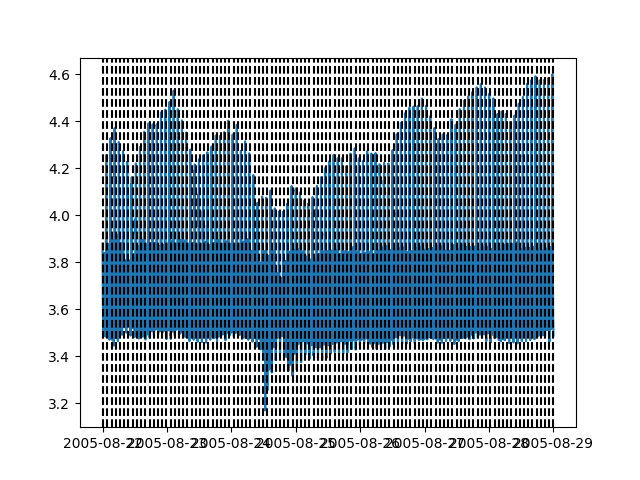

In [24]:
plt.figure()
plt.plot(CD_GITM_DRIA['C_D'])
for i in range(len(orbit_end_sel)):
    plt.axvline(x=orbit_end_sel[i],ls='--',c='k')

In [32]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = 'GRACEA_RSM_DRIA_GITM_'+ start.strftime("%Y-%m-%d") + ".csv"
RSM_CD_GITM_DRIA = pd.read_csv(filename)
RSM_CD_GITM_DRIA.index = pd.DatetimeIndex(RSM_CD_GITM_DRIA['Unnamed: 0'])
RSM_CD_GITM_DRIA_orbit = [RSM_CD_GITM_DRIA['C_D'][(RSM_CD_GITM_DRIA.index>=orbit_end[i])&(RSM_CD_GITM_DRIA.index<=orbit_end[i+1])].mean() for i in range(len(orbit_end)-1)]

In [33]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename='GRACEA_CLL_MSIS_' + start.strftime("%Y-%m-%d")+".csv"
CD_MSIS_CLL = pd.read_csv(filename)
CD_MSIS_CLL.index = pd.DatetimeIndex(CD_MSIS_CLL['Unnamed: 0'])
CD_MSIS_CLL_orbit = [CD_MSIS_CLL['C_D'][(CD_MSIS_CLL.index>=orbit_end[i])&(CD_MSIS_CLL.index<=orbit_end[i+1])].mean() for i in range(len(orbit_end)-1)]


In [8]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename='GRACEA_CLL_GITM_' + start.strftime("%Y-%m-%d")+".csv"
CD_GITM_CLL = pd.read_csv(filename)
CD_GITM_CLL.index = pd.DatetimeIndex(CD_GITM_CLL['Unnamed: 0'])

FileNotFoundError: [Errno 2] No such file or directory: 'GRACEA_CLL_GITM_2005-08-01.csv'

# compute $B^{*}$

In [34]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\TLE\\'
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/TLE/'
os.chdir(filepath)
filename = 'grace11.txt'
f = open(filename,'r')
Data = f.readlines()
f.close()

In [35]:
epochs = []; bstar = [];mean_motion = [];dn_o2=[]; delta_d=1.5;sma = [];
for i in range(int(len(Data)/2)):
    tle_str = 'GRACE\n' + Data[2*i] + Data[2*i + 1]
    tle_str = tle_str.strip().splitlines()
    tle = TLE.from_lines(*tle_str)
    # sma.append(tle.a)
    epochs.append(dt.datetime(tle.epoch_year,1,1,0,0,0) + dt.timedelta(days = tle.epoch_day - 1))
    bstar.append(tle.bstar)
    mean_motion.append(tle.n)
    dn_o2.append(tle.dn_o2)
epochs = pd.DatetimeIndex(epochs)
idx0 = np.where(epochs <= start + dt.timedelta(days=delta_d))[0][-1]
idx1 = np.where(epochs >= stop)[0][0]
idx = list(range(idx0,idx1))
fdg = epochs[idx]; DT = np.array([(fdg[i+1]-fdg[i])/dt.timedelta(seconds=1) for i in range(len(fdg)-1)]);
stu = list(np.where(DT == 0.0)[0]);
idx = [j for i, j in enumerate(idx) if i not in stu];
epochs = epochs[idx];
bstar = [bstar[idx0] for idx0 in idx]; 
mean_motion=[mean_motion[idx0] for idx0 in idx]; 
dn_o2=[dn_o2[idx0] for idx0 in idx];

In [22]:
epochs_c = epochs;sma_c = sma;

In [23]:
epochs_g = epochs; sma_g = sma

ValueError: x and y must have same first dimension, but have shapes (48,) and (0,)

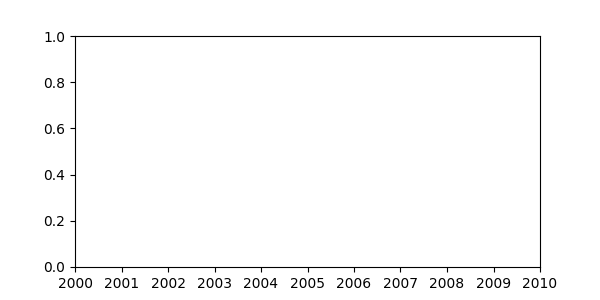

In [24]:
plt.figure(figsize=[6,3])
plt.plot(epochs_c,sma_c,lw=2,label = 'CNOFS semi-major axis',c='green')
plt.plot(epochs_g,sma_g,lw=2,label = 'GRACE semi-major axis',c='purple')
plt.ylabel('semi-major axis (km)',fontsize=12)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

datetime.datetime(2005, 9, 1, 0, 0)

## calculate $\Delta n_M^{2/3}$

In [39]:
rev2rad = 2*pi/86400; rev2rad2= rev2rad/86400;
n = np.array(mean_motion)*rev2rad;
dn = np.diff(n);
dn_dt = np.array(dn_o2)*2*rev2rad2;

NameError: name 'mean_motion' is not defined

In [40]:
bal_coeff_CLL = pd.DataFrame([CD_MSIS_CLL['C_D'][i]*CD_MSIS_CLL['A'][i]/m_grace for i in range(len(df1))],index=df1.index,columns=['B'])
bal_coeff_DRIA = pd.DataFrame([CD_MSIS_DRIA['C_D'][i]*CD_MSIS_DRIA['A'][i]/m_grace for i in range(len(df1))],index=df1.index,columns=['B'])

mu = 3.986*10**14

In [67]:
ratio = np.mean(Data_MSIS['rho'][:7200]/df1['Density_New (kg/m^3)'][:7200])

In [68]:
dn_m = []; n_est=[]; n0=n[0];n_i = n0;
for i in range(len(epochs)-1):
    t_i = epochs[i]
    t_k = epochs[i+1]
    idx = np.where((df1.index>=t_i)&(df1.index<=t_k))[0]
    dnm_dt= []; time_array=[];
    for idx0 in idx:
        rho=Data_MSIS['rho'][idx0]/ratio; v=df1['Velocity Magnitude (m/s)'][idx0]; 
        B_CLL =bal_coeff_CLL['B'][idx0];
        dnm_dt.append(rho * B_CLL * v**3)
        time_array.append((df1.index[idx0]-t_i)/dt.timedelta(seconds=1))
    n_k = (n_i**(2/3) + np.trapz(dnm_dt,x=time_array)*(mu**(-2/3)))**(3/2)
    n_est.append(n_k)
    dn_m.append(n_k-n_i)
    n_i = n_k
n_est_CLL = n_est
n_est_CLL.insert(0,n0)

    # n_insertappend(y)
        

In [69]:
dn_m = []; n_est=[]; n0=n[0];n_i = n0;
for i in range(len(epochs)-1):
    t_i = epochs[i]
    t_k = epochs[i+1]
    idx = np.where((df1.index>=t_i)&(df1.index<=t_k))[0]
    dnm_dt= []; time_array=[];
    for idx0 in idx:
        rho=Data_MSIS['rho'][idx0]/ratio; v=df1['Velocity Magnitude (m/s)'][idx0]; 
        B_CLL =bal_coeff_DRIA['B'][idx0];
        dnm_dt.append(rho * B_CLL * v**3)
        time_array.append((df1.index[idx0]-t_i)/dt.timedelta(seconds=1))
    n_k = (n_i**(2/3) + np.trapz(dnm_dt,x=time_array)*(mu**(-2/3)))**(3/2)
    n_est.append(n_k)
    dn_m.append(n_k-n_i)
    n_i = n_k
n_est_DRIA = n_est
n_est_DRIA.insert(0,n0)


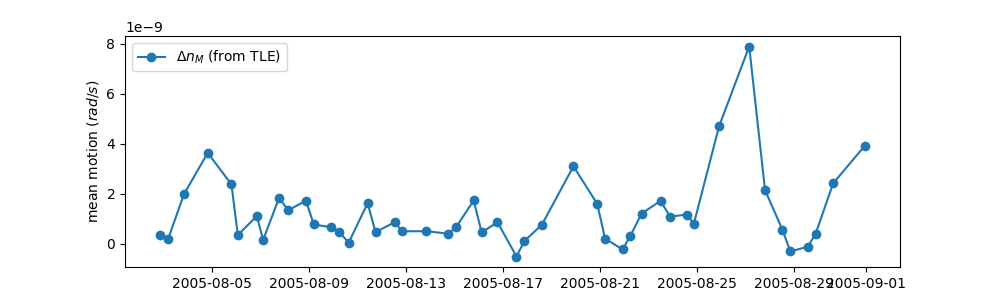

In [56]:
plt.figure(figsize=[10,3])
plt.plot(epochs[1:],np.diff(n),'-o',label='$\Delta n_{M}$ (from TLE)')
# plt.plot(epochs[1:],dn_m,'-o',label='$\Delta n_{M}$ (est)')
plt.yscale('linear')
plt.ylabel('mean motion ($rad/s$)')
plt.legend()
plt.show()

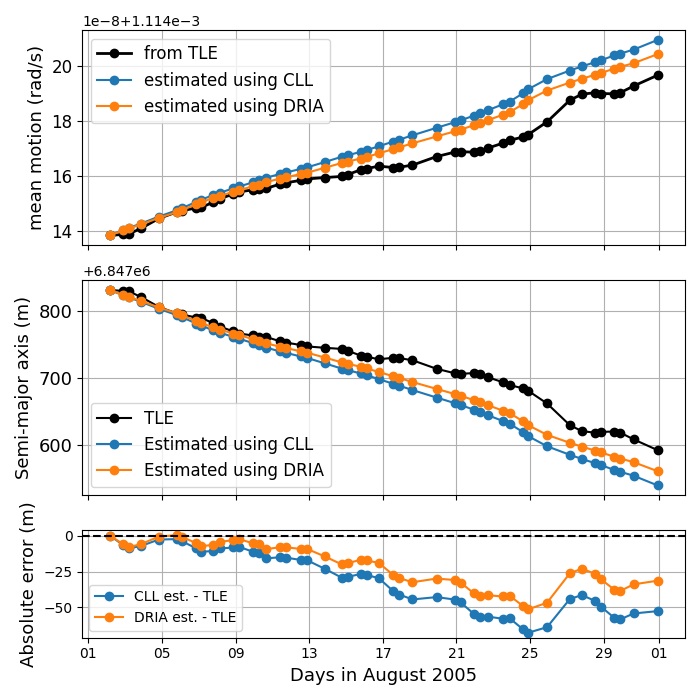

In [75]:
fig,ax = plt.subplots(3,1,figsize=[7,7],gridspec_kw={'height_ratios': [2,2,1]},sharex=True)
ax[0].plot(epochs,n,'-o',c='k',label='from TLE',lw=2)
ax[0].plot(epochs,n_est_CLL,'-o',label='estimated using CLL')
ax[0].plot(epochs,n_est_DRIA,'-o',label='estimated using DRIA')
ax[0].legend(fontsize=12)
ax[0].set_ylabel('mean motion (rad/s)',fontsize=13)
# ax[0].set_xlabel('Days in August 2005')
ax[0].tick_params(labelsize=12)
ax[0].xaxis.set_major_formatter(daysFmt);
# ax[0].set_title('Mean motion of GRACE for August 2005',fontsize=15)
ax[0].grid()

ax[1].plot(epochs,sma,'-o',c='k',label='TLE')
ax[1].plot(epochs,sma_est_CLL,'-o',label='Estimated using CLL')
ax[1].plot(epochs,sma_est_DRIA,'-o',label='Estimated using DRIA')
ax[1].legend(fontsize=12)
ax[1].set_ylabel('Semi-major axis (m)',fontsize=13)
# ax[0].set_xlabel('Days in August 2005')
ax[1].tick_params(labelsize=13)
ax[1].grid()
ax[1].xaxis.set_major_formatter(daysFmt);

ax[2].plot(epochs,sma_est_CLL-sma,'-o',label = 'CLL est. - TLE',c='tab:blue')
ax[2].plot(epochs,sma_est_DRIA-sma,'-o',label = 'DRIA est. - TLE',c='tab:orange')
ax[2].axhline(y=0,ls='--',lw=1.5,c='k')
ax[2].legend(loc='lower left')
ax[2].set_ylabel('Absolute error (m)',fontsize=13)
ax[2].set_xlabel('Days in August 2005',fontsize=13)
ax[2].grid()
# ax1[0].set_title('Semi-major axis of GRACE for August 2005',fontsize=13)
plt.tight_layout()
plt.show()


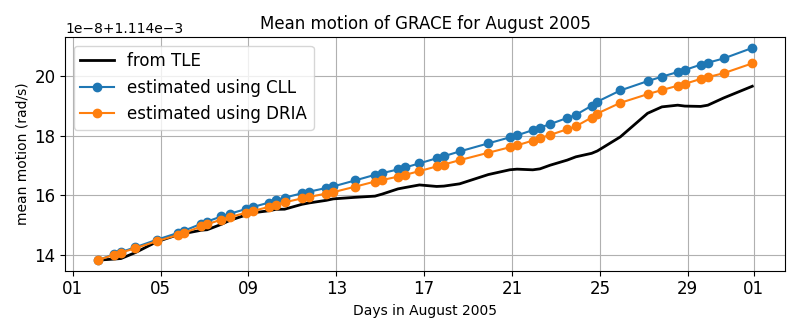

In [32]:
plt.figure(figsize=[8,3.33],dpi=100)
plt.plot(epochs,n,'-',c='k',label='from TLE',lw=2)
plt.plot(epochs,n_est_CLL,'-o',label='estimated using CLL')
plt.plot(epochs,n_est_DRIA,'-o',label='estimated using DRIA')
plt.legend(fontsize=12)
plt.ylabel('mean motion (rad/s)')
plt.xlabel('Days in August 2005')
plt.tick_params(labelsize=12)
ax = plt.gca()
ax.xaxis.set_major_formatter(daysFmt);
plt.title('Mean motion of GRACE for August 2005')
plt.tight_layout()
plt.grid()
plt.show()

In [70]:
sma = [(mu/(n**2))**(1/3)][0]
sma_est_CLL = [(mu/(np.array(n_est_CLL)**2))**(1/3)][0]
sma_est_DRIA = [(mu/(np.array(n_est_DRIA)**2))**(1/3)][0]

In [35]:
5*2/3

3.3333333333333335

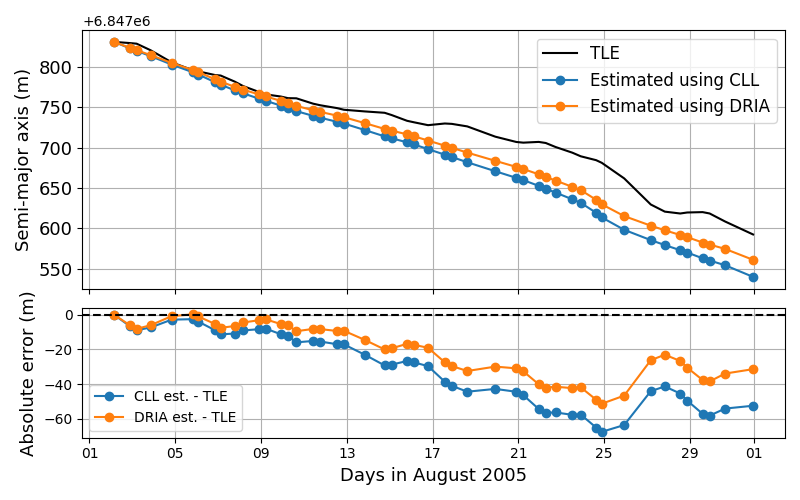

In [42]:
fig,ax1 = plt.subplots(2,1,figsize=[8,5],sharex=True,gridspec_kw={'height_ratios': [2,1]},dpi=100)
ax1[0].plot(epochs,sma,c='k',label='TLE')
ax1[0].plot(epochs,sma_est_CLL,'-o',label='Estimated using CLL')
ax1[0].plot(epochs,sma_est_DRIA,'-o',label='Estimated using DRIA')
ax1[0].legend(fontsize=12)
ax1[0].set_ylabel('Semi-major axis (m)',fontsize=13)
# ax[0].set_xlabel('Days in August 2005')
ax1[0].tick_params(labelsize=13)
ax1[0].grid()
ax = plt.gca()
ax.xaxis.set_major_formatter(daysFmt);

ax1[1].plot(epochs,sma_est_CLL-sma,'-o',label = 'CLL est. - TLE',c='tab:blue')
ax1[1].plot(epochs,sma_est_DRIA-sma,'-o',label = 'DRIA est. - TLE',c='tab:orange')
ax1[1].axhline(y=0,ls='--',lw=1.5,c='k')
ax1[1].legend(loc='lower left')
ax1[1].set_ylabel('Absolute error (m)',fontsize=13)
ax1[1].set_xlabel('Days in August 2005',fontsize=13)
ax1[1].grid()
# ax1[0].set_title('Semi-major axis of GRACE for August 2005',fontsize=13)
plt.tight_layout()
plt.show()


In [ ]:
fig,ax = plt.subplots(2,1,figsize=[8,5],sharex=True)
ax[0].plot(d,c='green')
ax[0].xaxis.set_major_formatter(daysFmt);
ax[0].set_ylabel('Pitch angle')

ax[1].plot(CNOFS_Data.index[:1440],yaw[:1440],c='purple')
ax[1].set_xlabel('UT on June 01, 2015')
ax[1].set_ylabel('Yaw angle')

plt.tight_layout()
plt.show()

# CD sensitivity

## wrt composition and temperature

In [43]:
v0 = 7500;
T_s0 = 300;
n0 = 1.0e14;
CD_CLL=[]; CD_DRIA=[];
O_He = np.arange(0.2,1.0,0.0025);
temp = np.arange(500,2001,2.5);
X,Y = np.meshgrid(O_He,temp);
X=X.ravel(); Y=Y.ravel();

In [44]:
CD_DRIA = np.zeros((len(O_He),len(temp)));
CD_CLL = np.zeros((len(O_He),len(temp)));

for i,x in tqdm(enumerate(O_He)):
    for j,y in enumerate(temp):
        m_avg = m_O*x + m_He*(1-x)
        nO = n0*x
        
        CD_O = drag_GRACE_DRIA(v0,R_O,y,0,0,m_avg,nO,T_s0,a,n_a)
        CD_He = drag_GRACE_DRIA(v0,R_He,y,0,0,m_avg,nO,T_s0,a,n_a)
        CD_DRIA[i,j] = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg

        CD_O = drag_GRACE_CLL(v0,R_O,y,0,0,m_avg,nO,T_s0,a,n_a)
        CD_He = drag_GRACE_CLL(v0,R_He,y,0,0,m_avg,nO,T_s0,a,n_a)
        CD_CLL[i,j] = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
CD_DRIA = np.transpose(CD_DRIA);
CD_CLL = np.transpose(CD_CLL); 

320it [06:32,  1.23s/it]


In [50]:
((np.max(CD_DRIA)-np.min(CD_DRIA))*100/np.mean(CD_DRIA))

44.92239643781372

In [49]:
((np.max(CD_CLL)-np.min(CD_CLL))*100/np.mean(CD_CLL))

44.43971291564973

In [74]:
# (CD_CLL[:,0] - CD_CLL[:,-1])/np.mean(CD_CLL,axis=1)
# (np.max(CD_DRIA)-np.min(CD_DRIA))/np.mean(CD_DRIA)
# x00 = (np.max(CD_DRIA,axis=0)-np.min(CD_DRIA,axis=0))/np.mean(CD_DRIA,axis=0)
# x01 = (np.max(CD_DRIA,axis=1)-np.min(CD_DRIA,axis=1))/np.mean(CD_DRIA,axis=1)
# (CD_DRIA[-1,:] - CD_DRIA[0,:])/np.mean(CD_DRIA,axis=0)
# (CD_CLL[-1,:] - CD_CLL[0,:])/np.mean(CD_CLL,axis=0)
# (CD_CLL[:,-1] - CD_CLL[:,0])/np.mean(CD_CLL,axis=1)
# (CD_DRIA[:,-1] - CD_DRIA[:,0])/np.mean(CD_DRIA,axis=1)
# (np.max(CD_DRIA)-np.min(CD_DRIA))/np.mean(CD_DRIA)
# (np.max(CD_CLL)-np.min(CD_CLL))/np.mean(CD_CLL)

In [51]:
CD_DRIA = CD_DRIA.ravel()
CD_CLL = CD_CLL.ravel()

In [76]:
# CD_DRIA = [];
# CD_CLL = [];

# for i,x in tqdm(enumerate(X)):
#     m_avg = m_O*x + m_He*(1-x)
#     nO = n0*x

#     CD_O = drag_GRACE_DRIA(v0,R_O,Y[i],0,0,m_avg,nO,T_s0,a,n_a)
#     CD_He = drag_GRACE_DRIA(v0,R_He,Y[i],0,0,m_avg,nO,T_s0,a,n_a)
#     CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
#     CD_DRIA.append(CD)

#     CD_O = drag_GRACE_CLL(v0,R_O,Y[i],0,0,m_avg,nO,T_s0,a,n_a)
#     CD_He = drag_GRACE_CLL(v0,R_He,Y[i],0,0,m_avg,nO,T_s0,a,n_a)
#     CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
#     CD_CLL.append(CD)


In [52]:
# idx = np.where(X >= 0.2)[0];
idx = np.arange(0,len(X))


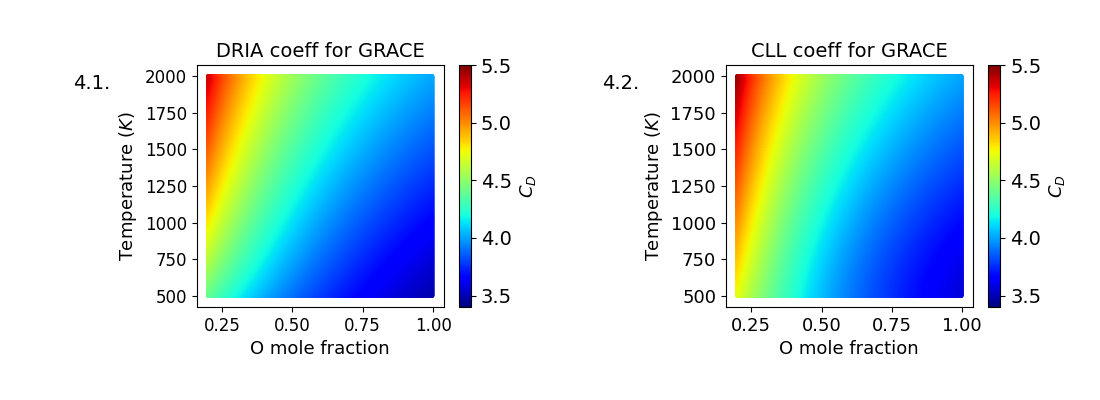

In [54]:
fig,ax = plt.subplots(1,2,figsize=[11,4],sharey=False)

# CD_DRIA_0 = np.mean([np.min(CD_DRIA[idx]),np.max(CD_DRIA[idx])])
# CD_CLL_0 = np.mean([np.min(CD_CLL[idx]),np.max(CD_CLL[idx])])

f0 = ax[0].scatter(X,Y,s=3,marker='o',c=CD_DRIA,cmap='jet',vmin=3.4,vmax=5.5)
ax[0].set_ylabel(r'Temperature ($K$)',fontsize=13)
ax[0].set_xlabel('O mole fraction',fontsize=13)
ax[0].set_title("DRIA coeff for GRACE",fontsize=14)
ax[0].tick_params(labelsize=12)
ax[0].set_yticks(np.arange(500,2001,250))
cbar = fig.colorbar(f0,ax=ax[0],label='$C_D$')
cbar.set_label(label='$C_{D}$', size=13, weight='bold')
cbar.ax.tick_params(labelsize=14)

f1 = ax[1].scatter(X,Y,s=3,marker='o',c=CD_CLL,cmap='jet',vmin=3.4,vmax=5.5)
# ax[1].set_ylabel('Temperature',fontsize=13)
ax[1].set_xlabel('O mole fraction',fontsize=13)
ax[1].set_ylabel(r'Temperature ($K$)',fontsize=13)
ax[1].set_title("CLL coeff for GRACE",fontsize=14)
ax[1].tick_params(labelsize=13)
ax[1].set_yticks(np.arange(500,2001,250))
cbar = fig.colorbar(f1,ax=ax[1],label='$C_D$')
cbar.set_label(label='$C_{D}$', size=13, weight='bold')
cbar.ax.tick_params(labelsize=14)


ax[0].text(-0.5, 0.9, "4.1.", transform=ax[0].transAxes, fontsize=14, color='k',weight='regular')
ax[1].text(-0.5, 0.9, "4.2.", transform=ax[1].transAxes, fontsize=14, color='k',weight='regular')

plt.tight_layout(pad=3.0)

filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
os.chdir(filepath);
filename = "GRACE_CD_sens_0.jpg";
plt.savefig(filename,format='jpg',dpi=1200)

plt.show()

In [60]:
v0 = 7500;
T_s0 = 300;
CD_CLL=[]; CD_DRIA=[];
temp0 = 1100;
X = np.arange(0,1.001,0.005)
n0 = 3.0e13;

## Case 1: O + He
CD_DRIA_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_DRIA(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_DRIA_1.append(CD)

## Case 2: O + H
CD_DRIA_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_DRIA(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_DRIA_2.append(CD)

## Case 2: O + H + He
CD_DRIA_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_DRIA(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_DRIA(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_DRIA_3.append(CD)

## Case 1: O + He
CD_CLL_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_CLL(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_CLL_1.append(CD)

## Case 2: O + H
CD_CLL_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_CLL(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_CLL_2.append(CD)

## Case 2: O + H + He
CD_CLL_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_CLL(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_CLL(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_CLL_3.append(CD)
case1 = {'CD_DRIA_1':CD_DRIA_1,'CD_DRIA_2':CD_DRIA_2,'CD_DRIA_3':CD_DRIA_3,
         'CD_CLL_1':CD_CLL_1,'CD_CLL_2':CD_CLL_2,'CD_CLL_3':CD_CLL_3,'n0':n0}

In [61]:
v0 = 7500;
T_s0 = 300;
CD_CLL=[]; CD_DRIA=[];
temp0 = 1100;
X = np.arange(0.0,1.001,0.005)
n0 = 1.0e14;
## Case 1: O + He
CD_DRIA_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_DRIA(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_DRIA_1.append(CD)

## Case 2: O + H
CD_DRIA_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_DRIA(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_DRIA_2.append(CD)

## Case 2: O + H + He
CD_DRIA_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_DRIA(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_DRIA(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_DRIA_3.append(CD)

## Case 1: O + He
CD_CLL_1 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_CLL(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_He*m_He*(1-x))/m_avg
    CD_CLL_1.append(CD)

## Case 2: O + H
CD_CLL_2 = [];
for x in X:
    m_avg = m_O*x + m_H*(1-x)
    nO = n0*x
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_CLL(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x))/m_avg
    CD_CLL_2.append(CD)

## Case 2: O + H + He
CD_CLL_3 = [];
for x in X:
    m_avg = m_O*x + m_He*(1-x)/2 + m_H*(1-x)/2
    nO = n0*x
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_CLL(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_H = drag_GRACE_CLL(v0,R_H,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x + CD_H*m_H*(1-x)/2 + CD_He*m_He*(1-x)/2)/m_avg
    CD_CLL_3.append(CD)
case2 = {'CD_DRIA_1':CD_DRIA_1,'CD_DRIA_2':CD_DRIA_2,'CD_DRIA_3':CD_DRIA_3,
         'CD_CLL_1':CD_CLL_1,'CD_CLL_2':CD_CLL_2,'CD_CLL_3':CD_CLL_3,'n0':n0}

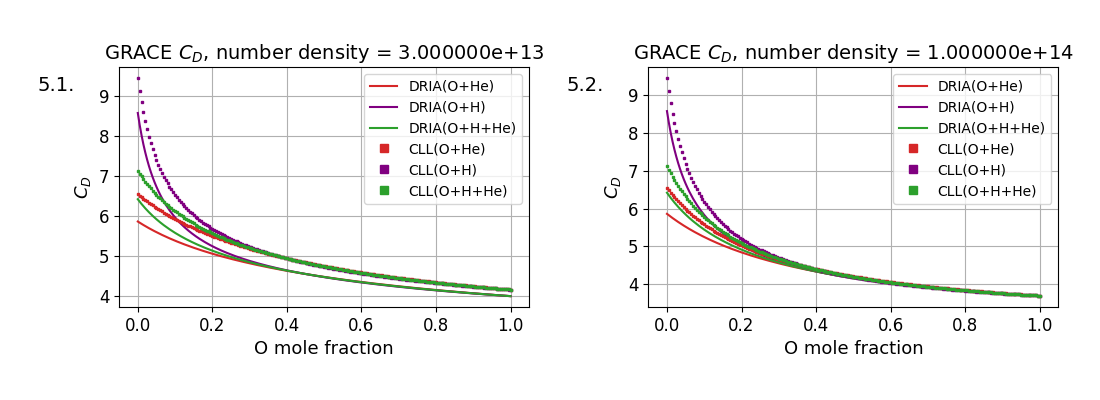

In [63]:
fig,ax = plt.subplots(1,2,figsize=[11,4])
ax[0].plot(X,case1['CD_DRIA_1'],'-',ms=3,label='DRIA(O+He)',c='tab:red')
ax[0].plot(X,case1['CD_DRIA_2'],'-',ms=3,label='DRIA(O+H)',c='purple')
ax[0].plot(X,case1['CD_DRIA_3'],'-',ms=3,label='DRIA(O+H+He)',c='tab:green')

ax[0].plot(X,case1['CD_CLL_1'],'s',ms=1.7,label='CLL(O+He)',c='tab:red')
ax[0].plot(X,case1['CD_CLL_2'],'s',ms=1.7,label='CLL(O+H)',c='purple')
ax[0].plot(X,case1['CD_CLL_3'],'s',ms=1.7,label='CLL(O+H+He)',c='tab:green')

ax[0].set_xlabel('O mole fraction',fontsize=13)
ax[0].set_ylabel('$C_D$',fontsize=13)
lgnd = ax[0].legend(loc='best',markerscale=3)

ax[0].set_title(r'GRACE $C_{D}$, number density = '+"{:e}".format(case1['n0']),fontsize=14)

ax[1].plot(X,case2['CD_DRIA_1'],'-',ms=3,label='DRIA(O+He)',c='tab:red')
ax[1].plot(X,case2['CD_DRIA_2'],'-',ms=3,label='DRIA(O+H)',c='purple')
ax[1].plot(X,case2['CD_DRIA_3'],'-',ms=3,label='DRIA(O+H+He)',c='tab:green')

ax[1].plot(X,case2['CD_CLL_1'],'s',ms=1.7,label='CLL(O+He)',c='tab:red')
ax[1].plot(X,case2['CD_CLL_2'],'s',ms=1.7,label='CLL(O+H)',c='purple')
ax[1].plot(X,case2['CD_CLL_3'],'s',ms=1.7,label='CLL(O+H+He)',c='tab:green')

ax[1].set_xlabel('O mole fraction',fontsize=13)
ax[1].set_ylabel('$C_D$',fontsize=13)
lgnd = ax[1].legend(loc='best',markerscale=3)

ax[1].set_title(r'GRACE $C_{D}$, number density = '+"{:e}".format(case2['n0']),fontsize=14)

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

ax[0].text(-0.2, 0.9, "5.1.", transform=ax[0].transAxes, fontsize=14, color='k')
ax[1].text(-0.2, 0.9, "5.2.", transform=ax[1].transAxes, fontsize=14, color='k')

ax[0].grid(which='both')
ax[1].grid(which='both')
plt.tight_layout(pad=3.0)

filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
os.chdir(filepath);
filename = "GRACE_CD_sens_1.jpg";
plt.savefig(filename,format='jpg',dpi=1200)

plt.show()

In [57]:
np.array(case2['CD_CLL_1']).max()/np.array(case2['CD_CLL_1']).min(),np.array(case2['CD_CLL_2']).max()/np.array(case2['CD_CLL_2']).min(),np.array(case2['CD_CLL_3']).max()/np.array(case2['CD_CLL_3']).min()

(1.7678186470709452, 2.551283452482901, 1.9245116081533362)

In [58]:
np.array(case2['CD_DRIA_1']).max()/np.array(case2['CD_DRIA_1']).min(),np.array(case2['CD_DRIA_2']).max()/np.array(case2['CD_DRIA_2']).min(),np.array(case2['CD_DRIA_3']).max()/np.array(case2['CD_DRIA_3']).min()

(1.5882521590305292, 2.3224558116368277, 1.739135923965943)

In [59]:
np.array(case1['CD_CLL_1'][0])/np.array(case1['CD_DRIA_1'][0]),np.array(case1['CD_CLL_2'][0])/np.array(case1['CD_DRIA_2'][0]),np.array(case1['CD_CLL_3'][0])/np.array(case1['CD_DRIA_3'][0])

(1.1167300495635033, 1.102151253634166, 1.1102402176114854)

In [22]:
# fig = plt.figure(figsize=[8,4],dpi=100)


In [22]:
# n0 = np.mean(Data_MSIS.iloc[:,2:8].sum(axis=1))
v0 = 7500
T_s0 = 300;
temp0 = 1100;
x0 = 1.0;
n = np.logspace(12,15,100,base=10)

## Case 1: O + He
CD_DRIA_1 = [];
for n0 in n:
    m_avg = m_O*x0 + m_He*(1-x0)
    nO = n0*x0
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_DRIA(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x0 + CD_He*m_He*(1-x0))/m_avg
    CD_DRIA_1.append(CD)
    
    
## Case 1: O + He
CD_CLL_1 = [];
for n0 in n:
    m_avg = m_O*x0 + m_He*(1-x0)
    nO = n0*x0
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_CLL(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*x0 + CD_He*m_He*(1-x0))/m_avg
    CD_CLL_1.append(CD)

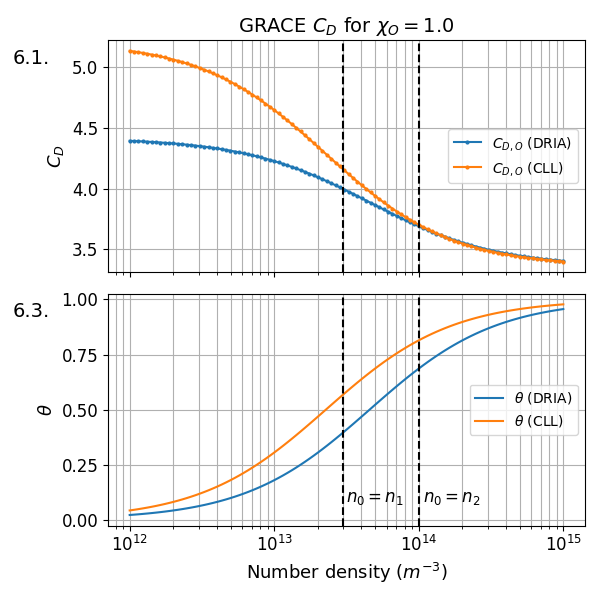

In [26]:
Po = n*x0*k_B*temp0
fig,ax = plt.subplots(2,1,sharex=True,figsize=[6,6])
ax[0].plot(n,CD_DRIA_1,'-o',ms=2,label=r'$C_{D,O}$ (DRIA)')
ax[0].plot(n,CD_CLL_1,'-o',ms=2,label=r'$C_{D,O}$ (CLL)')
ax[0].set_xscale('log')
ax[0].set_ylabel('$C_{D}$',fontsize=13)
ax[0].legend(loc='center right')
ax[0].set_title(r'GRACE $C_{D}$ for $\chi_{O} = 1.0$',fontsize=14)
ax[0].axvline(x=3.0e13,ls='--',c='k')
ax[0].axvline(x=1e14,ls='--',c='k')
ax[0].tick_params(labelsize=12)
ax[0].text(-0.2, 0.9, "6.1.", transform=ax[0].transAxes, fontsize=14, color='k')
ax[0].grid(which='both')

theta_DRIA = 1.44*10**6*Po/(1 + 1.44*10**6*Po)
theta_CLL = 2.89*10**6*Po/(1 + 2.89*10**6*Po)

ax[1].plot(n,theta_DRIA,label=r'$\theta$ (DRIA)')
ax[1].plot(n,theta_CLL,label=r'$\theta$ (CLL)')
ax[1].set_ylabel(r'$\theta$',fontsize=13)
ax[1].set_xlabel(r'Number density ($m^{-3}$)',fontsize=13)
ax[1].axvline(x=3.0e13,ls='--',c='k')
ax[1].axvline(x=1e14,ls='--',c='k')
ax[1].legend(loc='center right')
ax[1].tick_params(labelsize=12)
ax[1].text(-0.2, 0.9, "6.3.", transform=ax[1].transAxes, fontsize=14, color='k')
ax[1].set_yticks([0.0,0.25,0.50,0.75,1.0]);
ax[1].text(0.5, 0.1, r"$n_{0}=n_{1}$", transform=ax[1].transAxes, fontsize=12, color='k',weight='bold')
ax[1].text(0.66, 0.1, r"$n_{0}=n_{2}$", transform=ax[1].transAxes, fontsize=12, color='k',weight='bold')
ax[1].grid(which='both')

plt.tight_layout()
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
os.chdir(filepath);
filename = "GRACE_CD_sens_2.jpg";
plt.savefig(filename,format='jpg',dpi=1200)

plt.show()

In [18]:
3.6715-3.6854

-0.013900000000000023

## wrt pitch and yaw angle

In [64]:
n0 = 1.0e14
v0 = 7500;
T_s0 = 300; temp0 = 1100;
CD_CLL=[]; CD_DRIA=[];

pitch = np.deg2rad(np.linspace(-2,2,250));
yaw = np.deg2rad(np.linspace(-5,5,250));

X,Y = np.meshgrid(yaw,pitch);
X=X.ravel(); Y=Y.ravel();

frac_O = 1.0; frac_He = 1 - frac_O;
m_avg = frac_O*m_O + frac_He*m_He
nO = n0*frac_O

In [65]:
for i in tqdm(range(len(X))):
    
    CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,Y[i],X[i],m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_DRIA(v0,R_He,temp0,Y[i],X[i],m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*frac_O + CD_He*m_He*frac_He)/m_avg
    CD_DRIA.append(CD)
    
    CD_O =  drag_GRACE_CLL(v0,R_O,temp0,Y[i],X[i],m_avg,nO,T_s0,a,n_a)
    CD_He = drag_GRACE_CLL(v0,R_He,temp0,Y[i],X[i],m_avg,nO,T_s0,a,n_a)
    CD = (CD_O*m_O*frac_O + CD_He*m_He*frac_He)/m_avg
    CD_CLL.append(CD)

100%|███████████████████████████████████████████████████████████████████████████| 62500/62500 [02:15<00:00, 462.17it/s]


In [31]:
CD_O =  drag_GRACE_DRIA(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
CD_He = drag_GRACE_DRIA(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
CD_DRIA_0 = (CD_O*m_O*frac_O + CD_He*m_He*frac_He)/m_avg

CD_O =  drag_GRACE_CLL(v0,R_O,temp0,0,0,m_avg,nO,T_s0,a,n_a)
CD_He = drag_GRACE_CLL(v0,R_He,temp0,0,0,m_avg,nO,T_s0,a,n_a)
CD_CLL_0 = (CD_O*m_O*frac_O + CD_He*m_He*frac_He)/m_avg

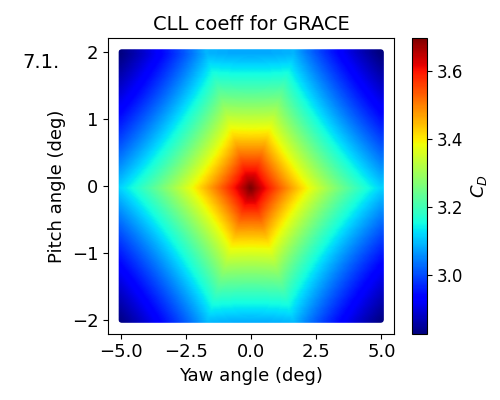

In [32]:
fig,ax = plt.subplots(1,1,figsize=[5,4],sharey=False)

# f0 = ax[0].scatter(np.rad2deg(X),np.rad2deg(Y),s=5,c=CD_DRIA,cmap='jet')
# ax[0].set_ylabel('Pitch angle (deg)',fontsize=13)
# ax[0].set_xlabel('Yaw angle (deg)',fontsize=13)
# ax[0].set_title("DRIA coeff for GRACE",fontsize=15)
# ax[0].tick_params(labelsize=13)
# cbar = fig.colorbar(f0,ax=ax[0],label=r'$C_{D}$')
# cbar.set_label(label=r'$C_{D}$', size='large', weight='bold')
# cbar.ax.tick_params(labelsize=12)

f1 = ax.scatter(np.rad2deg(X),np.rad2deg(Y),s=5,c=CD_CLL,cmap='jet')
# ax[1].set_ylabel('Pitch angle (deg)')
ax.set_xlabel('Yaw angle (deg)',fontsize=13)
ax.set_ylabel('Pitch angle (deg)',fontsize=13)

ax.set_title("CLL coeff for GRACE",fontsize=14)
ax.tick_params(labelsize=13)
ax.text(-0.3, 0.9, "7.1.", transform=ax.transAxes, fontsize=14, color='k')

cbar=fig.colorbar(f1,ax=ax,label=r'$C_{D}$')
cbar.set_label(label=r'$C_{D}$', size=13, weight='bold')
cbar.ax.tick_params(labelsize=12)


plt.tight_layout()
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
os.chdir(filepath)
plt.savefig("GRACE_CD_sens_3.jpg",format='jpg',dpi=1200)
plt.show()

In [33]:
np.min(CD_CLL)/np.max(CD_CLL)

0.7643717249139241

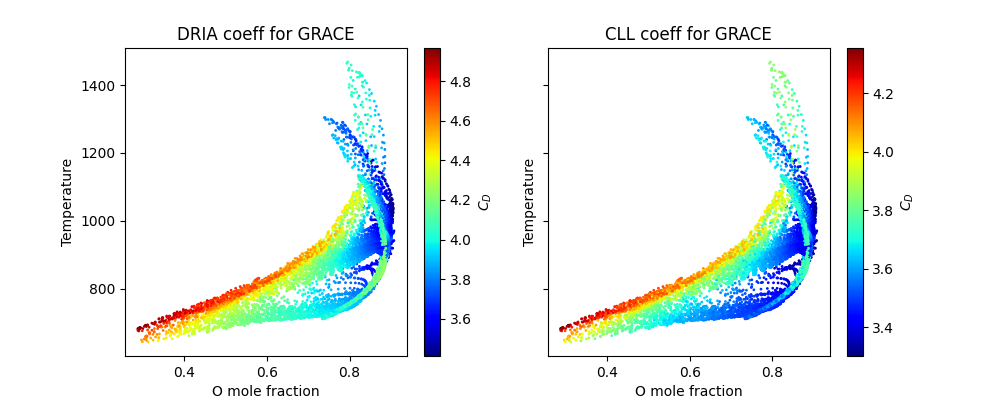

In [46]:
fig,ax = plt.subplots(1,2,figsize=[10,4],sharey=True)
f0 = ax[0].scatter(mole_frac_msis['O'],Data_MSIS['Tz'],s=1,c=CD_MSIS_CLL['C_D'],cmap='jet')
ax[0].set_ylabel('Temperature')
ax[0].set_xlabel('O mole fraction')
ax[0].set_title("DRIA coeff for GRACE")
fig.colorbar(f0,ax=ax[0],label='$C_D$')

f1 = ax[1].scatter(mole_frac_msis['O'],Data_MSIS['Tz'],s=1,c=CD_MSIS_DRIA['C_D'],cmap='jet')
ax[1].set_ylabel('Temperature')
ax[1].set_xlabel('O mole fraction')
ax[1].set_title("CLL coeff for GRACE")
fig.colorbar(f1,ax=ax[1],label='$C_D$')

## JB

In [49]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# # filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
# os.chdir(filepath)

# filename = 'JB_output_'+ sat + '_' + start.strftime('%Y-%m-%d') +'.csv'
# Data_JB = pd.read_csv(filename)
# Data_JB.index = pd.DatetimeIndex(Data_JB['Unnamed: 0'])
# Data_JB = Data_JB.drop('Unnamed: 0',axis=1)

In [50]:
# mole_frac = pd.DataFrame({'frac_O':[Data_JB['nO'][i]/sum(Data_JB.iloc[i,2:8]) for i in tqdm(range(len(Data_JB)))],
#                           'frac_Ar':[Data_JB['nAr'][i]/sum(Data_JB.iloc[i,2:8]) for i in tqdm(range(len(Data_JB)))],
#                          'frac_O2':[Data_JB['nO2'][i]/sum(Data_JB.iloc[i,2:8]) for i in tqdm(range(len(Data_JB)))],
#                           'frac_N2': [Data_JB['nN2'][i]/sum(Data_JB.iloc[i,2:8]) for i in tqdm(range(len(Data_JB)))],
#                           'frac_He': [Data_JB['nHe'][i]/sum(Data_JB.iloc[i,2:8]) for i in tqdm(range(len(Data_JB)))],
#                           'frac_H': [Data_JB['nH'][i]/sum(Data_JB.iloc[i,2:8]) for i in tqdm(range(len(Data_JB)))],
#                          },index = Data_JB.index);

In [51]:
# N=len(Data_JB); C_D = [];Area = [];
# drag_coeff = np.zeros((N,6))
# for i in tqdm(range(N)):
#     CD_O,A = drag_GRACE_CLL_2(GRACE_Data['Velocity Magnitude (m/s)'][i],R_O,Data_JB['Tz'][i],GRACE_Data['Pitch (rad)'][i],GRACE_Data['Yaw (rad)'][i],m_o,Data_JB['nO'][i],300)
#     CD_O2,_= drag_GRACE_CLL_2(GRACE_Data['Velocity Magnitude (m/s)'][i],R_O2,Data_JB['Tz'][i],GRACE_Data['Pitch (rad)'][i],GRACE_Data['Yaw (rad)'][i],m_o2,Data_JB['nO'][i],300)
#     CD_Ar,_= drag_GRACE_CLL_2(GRACE_Data['Velocity Magnitude (m/s)'][i],R_Ar,Data_JB['Tz'][i],GRACE_Data['Pitch (rad)'][i],GRACE_Data['Yaw (rad)'][i],m_Ar,Data_JB['nO'][i],300)
#     CD_N2,_= drag_GRACE_CLL_2(GRACE_Data['Velocity Magnitude (m/s)'][i],R_N2,Data_JB['Tz'][i],GRACE_Data['Pitch (rad)'][i],GRACE_Data['Yaw (rad)'][i],m_n2,Data_JB['nO'][i],300)
#     CD_He,_= drag_GRACE_CLL_2(GRACE_Data['Velocity Magnitude (m/s)'][i],R_He,Data_JB['Tz'][i],GRACE_Data['Pitch (rad)'][i],GRACE_Data['Yaw (rad)'][i],m_He,Data_JB['nO'][i],300)
#     CD_H,_= drag_GRACE_CLL_2(GRACE_Data['Velocity Magnitude (m/s)'][i],R_H,Data_JB['Tz'][i],GRACE_Data['Pitch (rad)'][i],GRACE_Data['Yaw (rad)'][i],m_H,Data_JB['nO'][i],300)
#     drag_coeff[i,:] = [CD_O,CD_O2,CD_Ar,CD_N2,CD_He,CD_H]
#     num = (m_o*mole_frac['frac_O'][i]*CD_O) + (m_o2*mole_frac['frac_O2'][i]*CD_O2) + (m_Ar*mole_frac['frac_Ar'][i]*CD_Ar) +(m_n2*mole_frac['frac_N2'][i]*CD_N2) + (m_He*mole_frac['frac_He'][i]*CD_He) + (m_H*mole_frac['frac_H'][i]*CD_H)
#     den = (m_o*mole_frac['frac_O'][i]) + (m_o2*mole_frac['frac_O2'][i]) + (m_Ar*mole_frac['frac_Ar'][i]) +(m_n2*mole_frac['frac_N2'][i]) + (m_He*mole_frac['frac_He'][i]) + (m_H*mole_frac['frac_H'][i])
#     C_D.append(num/den)
#     Area.append(A)
# C_D = pd.DataFrame({'C_D':C_D,'A':Area},index = Data_JB.index[:N])
# drag_coeff = pd.DataFrame(drag_coeff)
# drag_coeff.index = pd.DatetimeIndex(Data_JB.index)
# drag_coeff.columns = ["CD_O","CD_O2","CD_Ar","CD_N2","CD_He","CD_H"]

In [52]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# # filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
# os.chdir(filepath)
# filename = 'GRACE_CLL_JB_variable_theta' + start.strftime('%Y-%m-%d') + '.csv'
# C_D.to_csv(filename)

In [53]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# # filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
# os.chdir(filepath)
# filename = 'GRACE_CLL_JB_variable_theta_all_elements'+ start.strftime('%Y-%m-%d') +'.csv'
# drag_coeff.to_csv(filename)

In [54]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\RSM_MSIS\\GRACE\\Feb 05\\"
# # filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
# os.chdir(filepath)
# species = ['O','O2','N','N2','H','He']
# for s in species:
#     filename = 'GRACEA_RSM_CD_' + s + '_' + start.strftime("%Y-%m-%d") + '.txt'
#     exec("CD_" + s + "=pd.read_csv(filename)")


In [55]:
# # rows = np.arange(0,len(GRACE_Data),3)
# df1 = GRACE_Data
# df2 = Data_MSIS
# df3 = mole_frac

In [56]:
# #function to remove nan elements from a list
# def remove_nan(l):
#     return [x for x in l if str(x) != 'nan']
# #function to remove NaT from a list
# def remove_NaT(l):
#     return [x for x in l if str(x) != 'NaT']

In [57]:
# CD_RSM = []
# for i in range(len(GRACE_Data)):
#     num = (m_o*df3['frac_O'][i]*CD_O['C_D'][i]) + (m_o2*df3['frac_O2'][i]*CD_O2['C_D'][i]) + (m_n*df3['frac_N'][i]*CD_N['C_D'][i]) +(m_n2*df3['frac_N2'][i]*CD_N2['C_D'][i]) + (m_He*df3['frac_He'][i]*CD_He['C_D'][i]) + (m_H*df3['frac_H'][i]*CD_H['C_D'][i])
#     den = (m_o*df3['frac_O'][i]) + (m_o2*df3['frac_O2'][i]) + (m_n*df3['frac_N'][i]) +(m_n2*df3['frac_N2'][i]) + (m_He*df3['frac_He'][i]) + (m_H*df3['frac_H'][i])
#     CD_RSM.append(num/den)
# CD_RSM = pd.DataFrame({'C_D':CD_RSM},index = GRACE_Data.index)

In [58]:
# time_avg = remove_NaT([GRACE_Data.index[(GRACE_Data.index >= orbit_end[i]) & (GRACE_Data.index <= orbit_end[i+1])].mean() for i in range(len(orbit_end)-1)])
# CD_NEW = remove_nan([np.mean(GRACE_Data['CD_New (~)'][(GRACE_Data.index >= orbit_end[i]) & (GRACE_Data.index <= orbit_end[i+1])]) for i in range(len(orbit_end)-1)])
# CD_RSM = remove_nan([np.mean(CD_RSM['C_D'][(CD_RSM.index >= orbit_end[i]) & (CD_RSM.index <= orbit_end[i+1])]) for i in range(len(orbit_end)-1)])
# CD = remove_nan([np.mean(C_D['C_D'][(C_D.index >= orbit_end[i]) & (C_D.index <= orbit_end[i+1])]) for i in range(len(orbit_end)-1)])

In [59]:
# plt.figure(figsize= [10,4])
# plt.plot(time_avg,CD_NEW,'-s',label = 'Mehta')
# plt.plot(time_avg,CD_RSM,'-o',label = 'RSM')
# plt.plot(time_avg,CD,'-o',label = 'closed-form solution')
# plt.ylabel('Drag coefficient',fontsize=10)
# plt.grid()
# plt.legend()

## Method 1: Variable alpha (converted to sigma_n)

In [60]:
# def drag_GRACE_CLL_1(v,R,temp,pitch,yaw,m_atm,nO,T_s):
#     def sigma_n(m_atm,m_s,nO,temp):
#         def theta(nO,temp):
#             K = 2.89 * 10**6
#             k_B = 1.38 * 10**-23
#             pO = nO*k_B*temp
#             return K*pO/(1 + (K*pO))
#         th = theta(nO,temp)
#         K_s = 3.0;
#         mu = m_atm/m_s
#         alpha_s = K_s*mu/((1+mu)**2)
#         alpha_co = 1
#         alpha_eff = (alpha_co*th) + (alpha_s*(1-th))
#         alpha_n = (2*alpha_eff) - 1
#         if alpha_n < 0:
#             alpha_n = 0
#         return 1 - sqrt(1 - alpha_n)
    
#     def drag_CLL_plane(v,R,temp,angle,sigma_t,sigma_n,T_s):
#         def gamma1(x):
#             return (1/(2*sqrt(pi)))*(exp(-x**2) + (sqrt(pi)*x*(1+erf(x))))
#         def gamma2(x):
#             return (1/(2*sqrt(pi)))*((x*exp(-x**2)) + (sqrt(pi)/2)*(1 + (2*(x**2)))*(1+erf(x)))
#         v_a = sqrt(2*R*temp)
#         v_w = sqrt(pi*R*T_s/2)
#         g = cos(angle)
#         s = v/v_a
#         C_D = (2/s)*((sigma_t*gamma1(g*s)*(1-(g**2))) + (((2-sigma_n)/s)*gamma2(g*s)*g) + (sigma_n*(v_w/v)*gamma1(g*s)*g))
#         return C_D
    
    
#     v_unit = (cos(pitch)*cos(yaw),cos(pitch)*sin(yaw),sin(pitch));
    
#     a = [0.9551567,0.9551567,3.1554792,0.2282913,3.1554792,0.2282913,2.1673620,6.0711120,0.0461901]
#     n_a = [(1,0,0),(-1,0,0),(0,0.766044,-0.642787),(0,-0.766044,0.642787),(0,-0.766044,-0.642787),(0,0.766044,0.642787),(0,0,-1),(0,0,1),(1,0,0)]
#     m_surf = [382,382,60,382,60,382,60,100,382]
#     area = 0; CD = 0;
    
#     for i,n in enumerate(n_a):
#         angle = arccos(dot(v_unit,n))
#         if angle < pi/2:
#             area = area + a[i]*cos(angle)
#         CD = CD + drag_CLL_plane(v,R,temp,angle,1,sigma_n(m_atm,m_surf[i],nO,temp),T_s)*a[i]
    
#     return CD/area,area